# CartoGRAPHs
## A Framework for Interpretable Network Visualizations 

----------
+ Network Layouts involve : 
    + local 
    + global 
    + importance
    + functional 


+ Network Categories involve : 
    + 2D Portrait
    + 3D Portrait
    + Topographic Map
    + Geodesic Map

----------

In [3]:
from cartographs_main import *

_____
# 1 | SELECT ONE NETWORK GRAPH
_____

In [9]:
#####################
# SELECT AN ORGANISM 
#####################

organism =  'human' #'yeast'

G = load_graph(organism)
d_genesym = load_genesymbols(G, organism)
l_features = list(d_genesym.values())

d_centralities = load_centralities(G, organism)
df_centralities = pd.DataFrame(d_centralities).T
essential_genes,non_ess_genes,notdefined_genes = load_essentiality(G, organism)
d_gene_sym = load_genesymbols(G, organism)

In [10]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s'%len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

#print('symbol list length:', len(l_features))
#print('dict. of centr. length:', len(d_centralities))
#print('Essentiality loaded (all genes):', len(essential_genes)+len(non_ess_genes)+len(notdefined_genes))

Number of nodes i.e. genes: 16376
Number of edges: 309355
Network density: 0.2%


In [11]:
# Human / Disease specific 

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}

_____
# 2 | LOAD AND SELECT ONF OF THE FOLLOWING FEATURES
_____

In [14]:
#######################################
# Select precalculated layout matrix
#######################################

#netlayout = 'local'
netlayout = 'global'
#netlayout = 'importance'
#netlayout = 'funct-bio'
#netlayout = 'funct-mol'
#netlayout = 'funct-cel'
#netlayout = 'funct-dis'

feature = netlayout
DM = load_structural_datamatrix(G ,organism,netlayout)

genes = []
for i in DM.index:
    if str(i) in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

____________
# 3 | SET VISUAL PRE-SETTINGS
____________

### CHOOSING GENERAL NODE- AND EDGE VISUAL PARAMETERS

In [15]:
#################
# E D G E S
#################

edge_width = 0.1
edge_colorlight = '#d3d3d3' # 'lightgrey'
edge_colordark = '#696969' 
opacity_edges = 0.1 


#################
# N O D E S
#################

opacity_nodes = 0.8
node_edge_col = '#696969' 

scale_factor = 0.1
size = list(draw_node_degree(G, scale_factor).values())
scale_factor3D = 0.025
size3d = list(draw_node_degree_3D(G, scale_factor3D).values())

nodesglow_diameter = 8.0
nodesglow_transparency = 0.001 # 0.01

### CHOOSING NODE COLOR SETTINGS

#### OPT 1 | DICTIONARY INPUT

In [16]:
#################
# D I C T: {geneID:value} > different values = differently colored nodes 
#################

# EXAMPLE: Closeness Centrality 

# Text identifier for file output name
color_method = 'clos'

# choose a dictionary 
d_clos = {}
for k,v in d_centralities.items():
    d_clos[k] = v[1]

d_nodecol = d_clos 

# choose a color palette 
col_pal = 'YlOrRd'

# choose a text identifier for file output name
color_method = 'clos'

# assigning colors to nodes based on previous settings
d_colours = color_nodes_from_dict(G, d_nodecol, palette = col_pal)
colours = list(d_colours.values())

edge_color = '#d3d3d3'

#### OPT 2 | HUBS

In [42]:
# Text identifier for file output name
color_method = 'hubs'

# Choose color of hubs 
node_col = '#008a00' 
neigh_col_nodes = '#B9D770' 

# Identify hubs (using tresholds) 
min_treshold = 1000
max_treshold = 5000
hubs,neighs = get_hubs(G, max_treshold, min_treshold)
colours = list(color_nodes_hubs(G, hubs, neighs, node_col, neigh_col_nodes).values())
print('Selected No. of Hubs: ', len(hubs))

# Get edges from hubs 
d_edge_col_ = color_edges_from_genelist(G, list(hubs.keys()), node_col)

# Get rest edges 
rest_col_edges = '#d3d3d3'
d_rest_edges={}
for e in G.edges():
    if e not in d_edge_col_.keys():
        d_rest_edges[e] = rest_col_edges

d_all_edges = {**d_edge_col_, **d_rest_edges}
d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
edge_color = list(d_all_edges_sort.values())

Selected No. of Hubs:  12


#### OPT 3 | ESSENTIAL NODES

In [47]:
# Text identifier for file output name
color_method = 'essent'

# Choose colors 
node_col = '#00abff' 
undefined_col = '#d3d3d3'
rest_col_nodes = '#d3d3d3'
rest_col_edges = '#f5f5f5'
colours = color_nodes_from_list(G, essential_genes, node_col)

# Choose edges to highlight that link inbetween 2 essential genes only 
d_edge_col = color_edges_from_nodelist_x(G, essential_genes, node_col)

# Rest edges 
d_rest_edges={}
for e in G.edges():
    if e not in d_edge_col_.keys():
        d_rest_edges[e] = rest_col_edges

d_all_edges = {**d_edge_col_, **d_rest_edges}
d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
edge_color = list(d_all_edges_sort.values())

#### OPT 4 | A SPECIFIC DISEASE (for homo sapiens only)

In [49]:
# ----------------------------------------------------        
# get disease categories
# ----------------------------------------------------        
disease_categories = {}
for d_name in d_names_do.keys():
    #if d_name.find(disease_category) != -1:
        try:
            disease_categories[d_name,d_names_do[d_name]]=len(d_do_genes[d_names_do[d_name]])
            #print('specific disease: %s (%s) ; # associated genes: %s' %(d_name,d_names_do[d_name],len(d_do_genes[d_names_do[d_name]])))
        except:
            pass

# ----------------------------------------------------        
# search specific term + count of genes associated with disease 
# ----------------------------------------------------   
min_diseasegenes = 350
max_diseasegenes = 450
search_term = ''

for k,v in disease_categories.items():
    if v >= min_diseasegenes and v<= max_diseasegenes and search_term in k[0]:
        print(k,v)

('carbohydrate metabolism disease', 'DOID:0050013') 428
('lower respiratory tract disease', 'DOID:0050161') 420
('autosomal dominant disease', 'DOID:0050736') 398
('autosomal recessive disease', 'DOID:0050737') 381
('cell type benign neoplasm', 'DOID:0060084') 385
('sensorineural hearing loss', 'DOID:10003') 435
('intestinal cancer', 'DOID:10155') 357
('hypertension', 'DOID:10763') 360
('dysthymic disorder', 'DOID:12139') 390
('cerebral degeneration', 'DOID:1443') 413
('dermatitis', 'DOID:2723') 387
('inner ear disease', 'DOID:2952') 442
('bone inflammation disease', 'DOID:3342') 389
('uterine disease', 'DOID:345') 437
('liver disease', 'DOID:409') 385
('glucose metabolism disease', 'DOID:4194') 428
('myopathy', 'DOID:423') 385
('ophthalmoplegia', 'DOID:539') 354
('retinal disease', 'DOID:5679') 424
('muscle tissue disease', 'DOID:66') 392
('refractive error', 'DOID:9835') 407
('substance dependence', 'DOID:9973') 371


In [96]:
# Choose Disease 
disease_category = 'cancer'
# Text identifier for file output name
color_method = disease_category

# Get Disease genes 
disease_genes = get_disease_genes(G, d_names_do, d_do_genes, disease_category)

# Node colors
node_col = '#d21404' # 'red'
rest_col_edges = '#f5f5f5' # 'whitesmoke'
rest_col_nodes = '#d3d3d3' # 'lightgrey'
colours = color_nodes_from_genelist(G, disease_genes, node_col, rest_col_nodes)

# Edge colors - based on gene list of selection 
d_edge_col_ = color_edges_from_genelist(G, disease_genes, node_col)

d_rest_edges={}
for e in G.edges():
    if e not in d_edge_col_.keys():
        d_rest_edges[e] = rest_col_edges
        
d_all_edges = {**d_edge_col_, **d_rest_edges}
d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
edge_color = list(d_all_edges_sort.values())

#### OPT 5 | MORE THAN 1 SPECIFIC DISEASE

In [ ]:
# CHECK + FIX !! (edges)

In [63]:
# Text identifier for file output name
color_method = 'fourdiseases'

# Choose diseases to be highlighted 
disease_one = 'carcinoma' #'leukemia' ###  
disease_two = 'schizophrenia' ###
disease_three = 'myopathy' # 'epilepsy' ###
disease_four = 'breast cancer'#'cardiomyopathy' ###

disease_genes_one = get_disease_genes(G, d_names_do, d_do_genes, disease_one)
disease_genes_two = get_disease_genes(G, d_names_do, d_do_genes, disease_two)
disease_genes_three = get_disease_genes(G, d_names_do, d_do_genes, disease_three)
disease_genes_four = get_disease_genes(G, d_names_do, d_do_genes, disease_four)

node_col_one = '#ff9a00' #orange
node_col_two = '#ffe700' #yellow
node_col_three = '#e50000' #red
node_col_four = '#a10000' #dark red

color_rest = '#d3d3d3'# '#696969'
rest_col_edges = '#f5f5f5' # 'whitesmoke'
rest_col_nodes = '#d3d3d3' # 'lightgrey'

d_col_one = color_nodes(disease_genes_one, node_col_one)
d_col_two = color_nodes(disease_genes_two, node_col_two)
d_col_three = color_nodes(disease_genes_three, node_col_three)
d_col_four = color_nodes(disease_genes_four, node_col_four)


# Node colors 
d_col_all = {**d_col_one, **d_col_two, **d_col_three, **d_col_four}

d_rest = {}
for g in G.nodes():
    if g not in d_col_all.keys():
        d_rest[g] = color_rest #'d3d3d3' #'696969', #'dimgrey' # 'rgba(50,50,50,0.5)'

d_col_all_unsort = {**d_col_all, **d_rest}
d_col_all_sorted = {key:d_col_all_unsort[key] for key in G.nodes()}
colours = list(d_col_all_sorted.values())


# Edge colors 

d_edge_col_one = color_edges_from_genelist(G, disease_genes_one, disease_one)
d_edge_col_two = color_edges_from_genelist(G, disease_genes_two, disease_two)
d_edge_col_three = color_edges_from_genelist(G, disease_genes_three, disease_three)
d_edge_col_four = color_edges_from_genelist(G, disease_genes_four, disease_four)

d_edge_col_ = {**d_edge_col_one,**d_edge_col_two,**d_edge_col_three,**d_edge_col_four}

d_rest_edges={}
for e in G.edges():
    if e not in d_edge_col_.keys():
        d_rest_edges[e] = rest_col_edges
        
d_all_edges = {**d_edge_col_, **d_rest_edges}
d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
edge_color = list(d_all_edges_sort.values())

#### OPT 6 | SPECIFIC GENE LIST

In [ ]:
#################
# EXAMPLE 1: PATIENT VARIANTS + SEEDS 
#################

# Text identifier for file output name
color_method = 'var_seeds'

# Load Gene Information for Gene lists 
variants = pd.read_csv('input/julias_variants_mod.txt')
variant_list = [str(i) for i in list(variants['variants'])]
variant_sym = pd.read_csv('input/julias_variants_sym.txt')
genes_sym_list = [str(i) for i in list(variant_sym['variant_sym'])]
d_gene_sym_variants = dict(zip(variant_list,genes_sym_list))

df_seeds = pd.read_csv('input/seeds_from_genelists.txt')
df_seeds.columns = ['seeds']
df_seeds_z = pd.read_csv('input/seeds_from_zNumbers.txt', sep='\n')
seeds_list = [str(i) for i in list(df_seeds['seeds'])]

d_seeds_idsym = {}
for k,v in d_gene_sym.items():
    for i in seeds_list:
        if v == i:
            d_seeds_idsym[k]=i
seed_list = list(d_seeds_idsym.keys())

genes_list = variant_list+seed_list
# or select any other gene list with gene EntrezIDs

#################
# EXAMPLE 2:  AUTOCORE 
#################

# Text identifier for file output name
#color_method = 'autocore' 

#G_AC = nx.read_edgelist("input/autocore_edgelist.txt")
#genes_list = list(G_AC.nodes()

In [82]:
# Choose List of Genes (by EntrezID) 
genes_list = variant_list+seed_list # gene list from Example 1 above

# Choose colors 
node_col = '#8b0000' #'red' # '#FF0000'
rest_col_edges = '#f5f5f5' # 'whitesmoke'
rest_col_nodes = '#d3d3d3' # 'lightgrey'


# List of Input Gene list to highlist 
l_genes = genes_list
colours = color_nodes_from_list(G, l_genes, node_col)
d_edge_col_ = color_edges_from_nodelist(G, l_genes, node_col)



# CHECK + FIX 

# highlight edges from only specific genes: 
#l_genes = ['1794']
#d_edge_col_ = color_edges_from_genelist(G, l_genes, node_col)

#d_rest_edges={}
#for e in G.edges():
#    if e not in d_edge_col_.keys():
#        d_rest_edges[e] = rest_col_edges
        
#d_all_edges = {**d_edge_col_, **d_rest_edges}
#d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
#edge_color = list(d_all_edges_sort.values())

In [83]:
#################
#
# SPECIFIC GENES 
#
#################

# Text identifier for file output name
color_method = 'genes'

# Choose gene with "Gene symbol"
genesym_list = ['APP', 'ELAVL1']

d_idsym = {}
for k,v in d_gene_sym.items():
    for i in genesym_list:
        if v == i:
            d_idsym[k]=i
l_genes = list(d_idsym.keys())
d_edge_col_ = color_edges_from_genelist(G, l_genes, 'dimgrey')

____________
# 4 | LAYOUTS
____________

___
## 2D PORTRAIT
___

In [101]:
layoutcategory = '2D'

### DIMENSIONALITY REDUCTION

#### TSNE

In [ ]:
%%time 

# Specifying dim. red. method for file name
dimred = 'tsne'

prplxty = 50 # range: 5-50
density =1.2 # default 12.
l_rate = 1000 # default 200.
steps = 1000 # min 250
metric = 'cosine'

r_scale = 1.2
tsne2D = embed_tsne_2D(DM, prplxty, density, l_rate, steps, metric)
posG_complete_tsne_norm = get_posG_2D_norm(G, DM, tsne2D, r_scale)

#### UMAP

In [106]:
%%time 

# Specifying dim. red. method for file name
dimred = 'umap'

n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.0 # defines how dense points are stacked together 
metric ='cosine'

r_scale = 1.2
umap2D = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)
posG_complete_umap_norm = get_posG_2D_norm(G, DM, umap2D, r_scale)

CPU times: user 3min 32s, sys: 5.55 s, total: 3min 38s
Wall time: 1min 4s


--------------------

### PLOT

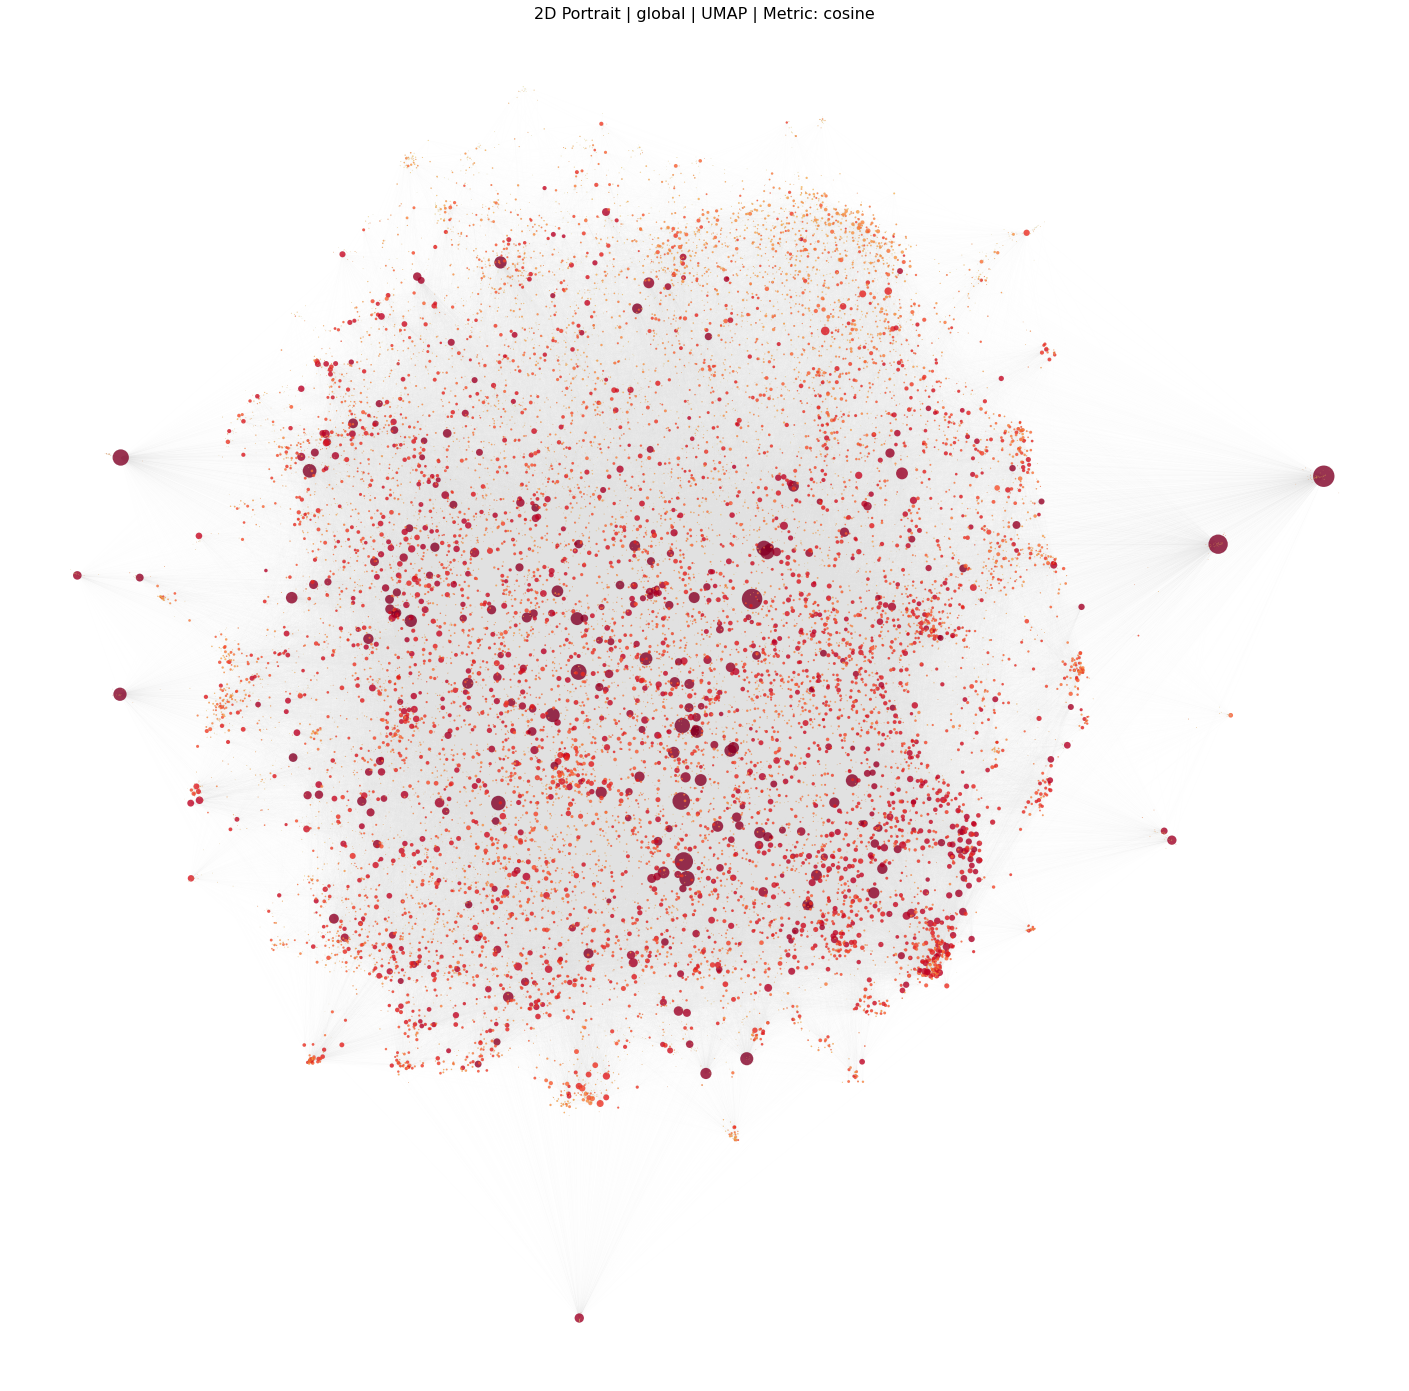

In [159]:
plt.figure(figsize=(25,25))
plt.title('2D Portrait | '+feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, 
                       posG_complete_umap_norm,
                       edgecolors = node_edge_col, 
                       linewidths = 0.05, 
                       node_color = colours, 
                       node_size = size, 
                       alpha = opacity_nodes)

# Uncomment to add Node Glow 

#nx.draw_networkx_nodes(G, 
#                       posG_complete_umap_norm,
#                       edgecolors = node_edge_col, 
#                       linewidths = 0.5, 
#                       node_color = colours, 
#                       node_size = 50.0, 
#                       alpha = 0.05)

nx.draw_networkx_edges(G, posG_complete_umap_norm, width = edge_width, 
                       edge_color = edge_colorlight, alpha = opacity_edges)


plt.box(False)

if dimred == 'umap':
    fname = 'output_plots/2Dlayouts/2DPortrait_umap_'+feature+'_col-'+color_method+'_neigh-'+str(n_neighbors)+'_spr-'+str(spread)+'_mindist-'+str(min_dist)+'_'+organism

elif dimed == 'tsne':
    fname = 'output_plots/2Dlayouts/2DPortrait_tsne_'+feature+'_col-'+color_method+'_prplx-'+str(prplxty)+'_dens-'+str(density)+'_learn-'+str(l_rate)+'_'+'stp-'+str(steps)+'_'+organism

# PNG
plt.savefig(fname+'.png',dpi=300)

# PDF 
plt.savefig(fname+'.pdf',format='pdf')

plt.show()

#### UMAP EXPORT TO CSV FOR VRNETZER INPUT 

In [119]:
export_to_csv2D(path='_VR_layouts/',
                layout_namespace = layoutcategory+'_'+netlayout, 
                posG = posG_complete_umap_norm, 
                colours = colours)

___
## TOPOGRAPHIC NETWORK MAP 
___

In [139]:
layoutcategory = 'topographic'

### DEFINITION OF Z-PARAMETER

#### OPT 1 | ESSENTIALITY STATE

In [123]:
# Text identifier for file output name
z_feat = 'z-ess'

value_ess = 10
value_noness = 5 
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1.0), axis=0, copy=True)

#### OPT 2 | AVERAGE OF CENTRALITY METRICS

In [131]:
# Text identifier for file output name
z_feat = 'z-centravg'

d_centr = {}
for i,j in df_centralities.iterrows():
    d_centr[str(i)] = (j[0]+j[1]+j[2])/3 # without eigenvalue
    
dict_z  = {key:d_centr[key] for key in G.nodes()}

z_list = list(dict_z.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1.0), axis=0, copy=True)

#### OPT 3 | NUMBER OF ASSOCIATED DISEASES

In [140]:
# Text identifier for file output name
z_feat = 'z-disease'

# Get Feature Matrix with genes as rows and columns as diseases
DM_feature  = pd.read_csv('_output_csv/Features_Disease_Dataframe_Human.csv', index_col=0)

# set gene list (= G.nodes())
genes_assoc = []
for i in DM_feature.index:
    genes_assoc.append(str(i))
    
genes_notassoc = [] 
for g in G.nodes():
    if g not in genes_assoc:
        genes_notassoc.append(g)

features_counted = (DM_feature == 1).astype(int).sum(axis=1)
d_features_counted = dict(zip(genes_assoc, list(features_counted)))
        
d_rest = {}
for i in genes_notassoc: 
    d_rest[i] = -20

d_param_unsorted = {**d_features_counted, **d_rest}
dict_z = {key:d_param_unsorted[key] for key in G.nodes()}

z_list = list(dict_z.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

________

### DIMENSIONALITY REDUCTION

#### TSNE

In [ ]:
# Take 2D coordinates from 2D Portrait and add z-parameter
# required: compute 2D portrait using TSNE 

posG_land_tsne = {}
cc = 0
for k,v in posG_complete_tsne_norm.items():
    posG_land_tsne[k] = (v[0],v[1],z_list_norm[cc])
    cc+=1

#### UMAP

In [141]:
# Take 2D coordinates from 2D Portrait and add z-parameter
# required: compute 2D portrait using UMAP

posG_land_umap = {}
cc = 0
for k,v in posG_complete_umap_norm.items():
    posG_land_umap[k] = (v[0],v[1],z_list_norm[cc])
    cc+=1

-------------------

### PLOT 

In [162]:
# Choose a color scheme (e.g. 'light' or 'dark')
scheme = 'dark' # or 'dark'

umap_nodes = get_trace_nodes_3D(posG_land_umap, l_features, colours, 
                                size3d, 
                                #1.0,
                                opacity_nodes)

# Uncomment to add Node Glow 
umap_nodes_glow = get_trace_nodes_3D(posG_land_umap, l_features, colours, 
                                nodesglow_diameter, 
                                nodesglow_transparency) 

if scheme == 'light':
    umap_edges = get_trace_edges_3D(G, posG_land_umap, edge_colorlight, opac = 0.05, linewidth=0.5)
elif scheme == 'dark':
    umap_edges = get_trace_edges_3D(G, posG_land_umap, edge_colordark, opac = 0.05, linewidth=0.5)
    #umap_specificedges = get_trace_edges_from_nodelist3D(list(d_edge_col_.keys()), posG_land_umap, 'dimgrey', 0.1)

umap_data = [umap_edges, #umap_specificedges,
             umap_nodes_glow,
             umap_nodes]

data = umap_data

if dimred == 'umap':
    fname = 'output_plots/3Dlayouts/TopographicMap_umap_'+feature+'_col-'+color_method+'_'+z_feat+'_neigh-'+str(n_neighbors)+'_spr-'+str(spread)+'_mindist-'+str(min_dist)+'_'+organism

elif dimed == 'tsne':
    fname = 'output_plots/3Dlayouts/TopographicMap_tsne_'+feature+'_col-'+color_method+'_'+z_feat+'_prplx-'+str(prplxty)+'_dens-'+str(density)+'_learn-'+str(l_rate)+'_'+'stp-'+str(steps)+'_'+organism
    
    
plot_3D(data, fname, scheme)#, annot_light)

'output_plots/3Dlayouts/TopographicMap_umap_global_clos_z-disease_neigh-20_spr-1.0_mindist-0.0_human.html'

#### UMAP EXPORT TO CSV FOR VRNETZER INPUT 

In [163]:
export_to_csv3D(path = '_VR_Layouts/',
                layout_namespace = layoutcategory+'_'+feature, 
                posG = posG_land_umap, 
                colours = colours)

____
## 3D PORTRAITS
____

In [17]:
layoutcategory = '3D'

### DIMENSIONALITY REDUCTION

#### TSNE 

In [ ]:
%%time 

# Specifying dim. red. method for file name
dimred = 'tsne'

prplxty = 50
density =1.2 
l_rate = 1000
steps = 1000
metric = 'cosine'

r_scale = 1.2
tsne_3D = embed_tsne_3D(DM, prplxty, density, l_rate, steps, metric)
posG_3D_tsne = get_posG_3D(genes, tsne_3D)
posG_3D_complete_tsne_norm = get_posG_3D_norm(G, DM, tsne3D, r_scale)

#### UMAP

In [18]:
%%time 

# Specifying dim. red. method for file name
dimred = 'umap'

n_neighbors = 20 
spread = 1.0
min_dist = 0.1  
metric='cosine'

umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)
posG_3D_umap = get_posG_3D(genes, umap_3D)
posG_3D_complete_umap_norm = get_posG_3D_norm(G, DM, umap_3D)

CPU times: user 3min 46s, sys: 6.92 s, total: 3min 53s
Wall time: 1min 19s


-------------------

### PLOT 

In [26]:
# Choose a color scheme (e.g. 'light' or 'dark')
#scheme = 'light'
scheme = 'dark'

umap_nodes = get_trace_nodes_3D(posG_3D_complete_umap_norm, l_features, colours, 
                                size3d, #1.0
                                opacity_nodes)

umap_nodes_glow = get_trace_nodes_3D(posG_3D_complete_umap_norm, l_features, colours, 
                                nodesglow_diameter, 
                                nodesglow_transparency) 

if scheme == 'light':
    umap_edges = get_trace_edges_3D(G, posG_3D_complete_umap_norm, edge_colorlight, opac = 0.05, linewidth=0.5)
elif scheme == 'dark':
    umap_edges = get_trace_edges_3D(G, posG_3D_complete_umap_norm, edge_colordark, opac = 0.05, linewidth=0.5)

umap_data = [umap_edges,
             umap_nodes_glow,
             umap_nodes]

data = umap_data

if dimred == 'umap':
    fname = 'output_plots/3Dlayouts/3DPortrait_umap_'+feature+'_col-'+color_method+'_neigh-'+str(n_neighbors)+'_spr-'+str(spread)+'_mindist-'+str(min_dist)+'_'+organism

elif dimed == 'tsne':
    fname = 'output_plots/3Dlayouts/3DPortrait_tsne_'+feature+'_col-'+color_method+'_prplx-'+str(prplxty)+'_dens-'+str(density)+'_learn-'+str(l_rate)+'_'+'stp-'+str(steps)+'_'+organism
    
    
plot_3D(data, fname, scheme)#, annot_light)

'output_plots/3Dlayouts/3DPortrait_umap_global_col-clos_neigh-20_spr-1.0_mindist-0.1_human.html'

#### UMAP EXPORT TO CSV FOR VRNETZER INPUT 

In [175]:
posG_3D_complete_umap_norm_num = {}
for node_id,coords in posG_3D_complete_umap_norm.items():
    posG_3D_complete_umap_norm_num[only_numerics(node_id)]=coords
    
export_to_csv3D(path='_VR_layouts/',
                layout_namespace = layoutcategory+'_'+netlayout, 
                posG = posG_3D_complete_umap_norm_num, 
                colours = colours)

----
## GEODESIC NETWORK MAP 
----

In [176]:
layoutcategory = 'geodesic'

### DEFINITION OF RADIUS PARAMETER

#### OPT 1 | GENE LIST

In [235]:
#################
# EXAMPLE : PATIENT VARIANTS + SEEDS 
#################

# Text identifier for file output name
rad_param = 'r-varseeds'

# Load Gene Information for Gene lists 
variants = pd.read_csv('input/julias_variants_mod.txt')
variant_list = [str(i) for i in list(variants['variants'])]
variant_sym = pd.read_csv('input/julias_variants_sym.txt')
genes_sym_list = [str(i) for i in list(variant_sym['variant_sym'])]
d_gene_sym_variants = dict(zip(variant_list,genes_sym_list))

df_seeds = pd.read_csv('input/seeds_from_genelists.txt')
df_seeds.columns = ['seeds']
df_seeds_z = pd.read_csv('input/seeds_from_zNumbers.txt', sep='\n')
seeds_list = [str(i) for i in list(df_seeds['seeds'])]

d_seeds_idsym = {}
for k,v in d_gene_sym.items():
    for i in seeds_list:
        if v == i:
            d_seeds_idsym[k]=i
seed_list = list(d_seeds_idsym.keys())

FM_BP = pd.read_csv('_output_csv/Features_GO_BiolProc_Dataframe_human.csv', index_col=0)
bioproc_list = list(FM_BP.index)

# From obtained Gene lists select those to be mapped onto different shells 
# select genes for shells 
shell_one = variant_list
shell_two = seed_list
shell_three = [str(i) for i in bioproc_list]

small_rad = 1
mid_rad = 5
large_rad = 30
outershell_rad = 50

d_param = {}
for i in G.nodes():
    if str(i) in variant_list:
        d_param[str(i)] = small_rad
    elif i in seed_list:
        d_param[str(i)] = mid_rad 
    elif int(i) in bioproc_list:
        d_param[str(i)] = large_rad 
    else:
        d_param[str(i)] = outershell_rad

genes_rad = variant_list + seed_list + bioproc_list

# check how many shells of spheres there will be :
print('Number of Spherical Shells:', len(set(d_param.values())))


# Specifying coloring based on genes on different shells 
d_nodecol = d_clos 
d_colours = color_nodes_from_dict(G, d_nodecol, palette = col_pal)

d_colours_spec_genes = {}
for k,v in d_colours.items():
    if k in shell_one:
        d_colours_spec_genes[k]='#8b0000' 
    elif k in shell_two:
        d_colours_spec_genes[k]='#FF4500' 
    elif k in shell_three:
        d_colours_spec_genes[k]=v
    else: 
        d_colours_spec_genes[k]='#d3d3d3'

d_colours_spec_genes_sort = {key:d_colours_spec_genes[key] for key in G.nodes()}
colours = list(d_colours_spec_genes_sort.values())

Number of Spherical Shells: 4


#### OPT 2 | ESSENTIALITY

In [278]:
# Text identifier for file output name
rad_param = 'r-essent'

small_rad = 1
mid_rad = 10
outershell_rad = 20

d_ess_scores = {}
for i in G.nodes():
    if i in essential_genes:
        d_ess_scores[i] = small_rad
    elif i in non_ess_genes:
        d_ess_scores[i] = mid_rad
    elif str(i) in notdefined_genes:
        d_ess_scores[i] = outershell_rad
        
d_param = d_ess_scores
genes_rad = list(G.nodes())

# check how many shells of spheres there will be :
print('Number of Spherical Shells:', len(set(d_param.values())))


# Specifying coloring based on genes on different shells 
d_colours_spec_genes = {}
for k in G.nodes():
    if k in essential_genes:
        d_colours_spec_genes[k]='#0080bf' 
    elif k in non_ess_genes:
        d_colours_spec_genes[k]='#95dcff' 
    else: 
        d_colours_spec_genes[k]='#d3d3d3'

d_colours_spec_genes_sort = {key:d_colours_spec_genes[key] for key in G.nodes()}
colours = list(d_colours_spec_genes_sort.values())

Number of Spherical Shells: 3


______

### DIMENSIONALITY REDUCTION 

#### UMAP

In [199]:
%%time 

n_neighbors = 50 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 # defines how dense points are stacked together 
metric='cosine'

umap_sphere = embed_umap_sphere(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 18min 8s, sys: 9.83 s, total: 18min 18s
Wall time: 3min 22s


In [279]:
%%time 

posG_sphere = get_posG_sphere(genes, umap_sphere)
posG_complete_sphere_norm = get_posG_sphere_norm(G, genes_rad, umap_sphere, d_param, 40)

CPU times: user 24.6 s, sys: 43.9 ms, total: 24.6 s
Wall time: 24.7 s


--------------------

### PLOT

In [280]:
# Choose a color scheme (e.g. 'light' or 'dark')
scheme = 'light'
#scheme = 'dark'

umap_nodes = get_trace_nodes_3D(posG_complete_sphere_norm, l_features, colours, 
                                #size3d, 
                                1.0,
                                opacity_nodes)

umap_nodes_glow = get_trace_nodes_3D(posG_complete_sphere_norm, l_features, colours, 
                                nodesglow_diameter, 
                                nodesglow_transparency) 

if scheme == 'light':
    umap_edges = get_trace_edges_3D(G, posG_complete_sphere_norm, edge_colorlight, opac = 0.05, linewidth=0.5)
elif scheme == 'dark':
    umap_edges = get_trace_edges_3D(G, posG_complete_sphere_norm, edge_colordark, opac = 0.05, linewidth=0.5)

    
#specific edges:
#umap_edges_spec = get_trace_edges_from_genelist3D(list(d_edge_col_.keys()),posG_complete_sphere_norm, node_col, 0.1)
#umap_data_edges_spec = [umap_edges_spec,umap_nodes_transparent, umap_nodes]




umap_data = [#umap_edges,
             #umap_nodes_glow,
             umap_nodes]

data = umap_data

if dimred == 'umap':
    fname = 'output_plots/3Dlayouts/GeodesicMap_umap_'+feature+'_col-'+color_method+'_neigh-'+str(n_neighbors)+'_spr-'+str(spread)+'_mindist-'+str(min_dist)+'_'+organism

elif dimed == 'tsne':
    fname = 'output_plots/3Dlayouts/GeodesicMap_tsne_'+feature+'_col-'+color_method+'_prplx-'+str(prplxty)+'_dens-'+str(density)+'_learn-'+str(l_rate)+'_'+'stp-'+str(steps)+'_'+organism
    
    
plot_3D(data, fname, scheme)#, annot_light)

'output_plots/3Dlayouts/GeodesicMap_umap_global_col-clos_neigh-50_spr-1.0_mindist-0.1_human.html'

#### UMAP EXPORT TO CSV FOR VRNETZER INPUT 

In [243]:
posG_complete_sphere_norm_num = {}
for node_id,coords in posG_complete_sphere_norm.items():
    posG_complete_sphere_norm_num[only_numerics(node_id)]=coords
    
export_to_csv3D(path='_VR_layouts/',
                layout_namespace = layoutcategory+'_'+netlayout, 
                posG = posG_complete_sphere_norm, 
                colours = colours)